This notebook ingests the CMP historical data and parses a traffix file then joins them.



In [1]:
import geopandas as gpd
%matplotlib inline
import pandas as pd

In [2]:
CMP_Int = gpd.read_file('data/CMP_Int.shp')

In [3]:
CMP_Int.columns

Index(['OBJECTID', 'STATUS', 'SCORE', 'SIDE', 'ARC_STREET', 'ID', 'CMP_SYSTEM',
       'CROSS_STRE', 'INTERSECTI', 'LOCATION', 'JURISDICTI', 'YR_1991',
       'YR_1992', 'YR_1993', 'YR_1994', 'YR_1996', 'YR_1997', 'YR_1998',
       'YR_2000', 'YR_2001', 'YR_2002', 'YR_2004', 'YR_2006', 'YR_2008',
       'YR_2010', 'LOS_RATING', 'LOS_2008', 'LOS_2006', 'LOS_2004', 'YR_2012',
       'ID_1', 'YR_2014', 'YR_2016', 'geometry'],
      dtype='object')

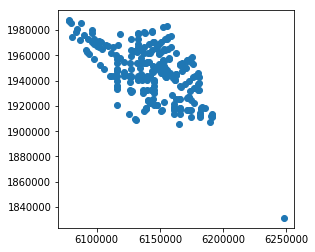

In [4]:
CMP_Int.plot()

In [5]:
CMP_Int.head()

,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,ID,CMP_SYSTEM,CROSS_STRE,INTERSECTI,LOCATION,...,YR_2010,LOS_RATING,LOS_2008,LOS_2006,LOS_2004,YR_2012,ID_1,YR_2014,YR_2016,geometry
0,54,T,100,,Lawrence Expy & State Hwy 82,1214.0,Lawrence Exp.,El Camino Real (Rte 82),Lawrence Expy & State Hwy 82,Santa Clara,...,C,6,6,6,7,C,1214.0,C,C,POINT (6126676.125025481 1954203.266779542)
1,55,T,100,,Saratoga Sunnyvale Rd & State Hwy 9,1301.0,Big Basin Way (Hwy 9),Saratoga-Los Gatos Rd.,Saratoga Sunnyvale Rd & State Hwy 9,Saratoga,...,D+,8,8,9,7,D+,1301.0,D+,D+,POINT (6115836.085681975 1920504.647497132)
2,56,T,100,,Sunnyvale Saratoga Rd & W Fremont Ave,1401.0,Saratoga-Sunnyvale Rd.,Fremont Av.,Sunnyvale Saratoga Rd & W Fremont Ave,Sunnyvale,...,D,9,9,0,9,D,1401.0,D,D,POINT (6116256.271849483 1954303.086461797)
3,57,M,100,,Sunnyvale Saratoga Rd & E Remington Dr,1402.0,Saratoga-Sunnyvale Rd.,Remington Dr.,Sunnyvale Saratoga Rd & E Remington Dr,Sunnyvale,...,C-,7,9,0,9,D,1402.0,D,D,POINT (6116376.9031699 1956841.440965131)
4,58,M,100,,E Remington Dr & State Hwy 82,1404.0,El Camino Real (Rte. 82),Fair Oaks Av.,E Remington Dr & State Hwy 82,Sunnyvale,...,D,9,8,9,9,D,1404.0,D,D,POINT (6118458.359308809 1957781.182195887)


In [6]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/2016CMP80_PM.xml')
# tree = ET.parse('data/CMP_80_traffix_write_file_single_xml.in.xml')
root = tree.getroot()

In [7]:
# for child in root:
#     print (child.tag)
#     print(child.attrib)

In [8]:
# node_dict = {}
# node_dict['index'] = node.attrib.get('index')
# node_dict['name'] = node.find('name').text
# node_dict['volcount_date_year'] = node.find('volumedata').find('volcountdate').get('year')
# node_dict['volcount_date_month'] = node.find('volumedata').find('volcountdate').get('month')
# node_dict['volcount_date_day'] = node.find('volumedata').find('volcountdate').get('day')
# node_dict['voltimeperiod'] = node.find('volumedata').find('voltimeperiod').text
# node_dict['los'] = node.find('resultdata').find('los').text
# node_dict['averagedelay'] = node.find('resultdata').find('averagedelay').get('val')
# node_dict['averagecriticaldelay'] = node.find('resultdata').find('averagecriticaldelay').get('val')

In [9]:
def node_parser(node):
    node_dict = {}
    node_dict['ID'] = node.attrib.get('index')
    node_dict['name'] = node.find('name').text
    node_dict['volcount_date_year'] = node.find('volumedata').find('volcountdate').get('year')
    node_dict['volcount_date_month'] = node.find('volumedata').find('volcountdate').get('month')
    node_dict['volcount_date_day'] = node.find('volumedata').find('volcountdate').get('day')
    node_dict['voltimeperiod'] = node.find('volumedata').find('voltimeperiod').text
    node_dict['los'] = node.find('resultdata').find('los').text
    node_dict['averagedelay'] = node.find('resultdata').find('averagedelay').get('val')
    node_dict['averagecriticaldelay'] = node.find('resultdata').find('averagecriticaldelay').get('val')#     print(node.find('volumedata').find('volcountdate').get('year'), node.find('volumedata').find('volcountdate').get('month'),node.find('volumedata').find('volcountdate').get('day'))
    return node_dict
#     print(node.find('volumedata').find('voltimeperiod').text)
# node_parser(node)

In [10]:
node_list = []
nodes = root.findall("node")
for node in nodes:
    node_list.append(node_parser(node))
    

In [11]:
df = pd.DataFrame(node_list)

In [12]:
df.head()

,ID,averagecriticaldelay,averagedelay,los,name,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod
0,101,28.51241,30.69518,C,Bascom/Campbell,6,12,2016,5:00 - 6:00 pm
1,102,56.93715,47.77116,D,Winchester/Hamilton,1,12,2016,4:30 PM to 5:30 PM
2,103,30.43571,25.11601,C,Hwy 17 NB/Hamilton,1,12,2016,4:45 - 5:45 PM
3,104,49.06350,52.22595,D-,Hwy 17 SB/Hamilton,13,12,2016,4:45 - 5:45 PM
4,105,52.74055,51.41155,D-,Bascom/Hamilton,2,1,2017,5:15 - 6:15 PM


In [13]:
tree = ET.parse('data/CMP_80_traffix_write_file_single_xml.in.xml')
root = tree.getroot()
node_list = []
nodes = root.findall("node")
# for node in nodes:
#     print(node)
#     node_list.append(node_parser(node))
    

In [14]:
#103 - <links ne="11708" e="105" se="11709" w="11704"/>
#104  <links nw="11708" e="11704" sw="11709" w="102"/>
def full_node_parser(node):
    node_dict = {}
    node_dict['ID'] = node.attrib.get('index')
    node_dict['name'] = node.find('name').text
    node_dict['xpos'] = node.find('position').get('xpos')
    node_dict['ypos'] = node.find('position').get('ypos')
    if node.find('links') is not None:
        links = []
        for each in node.find('links').keys():
            links.append(node.find('links').get(each))
        node_dict['links'] = ', '.join(links)

#     node_dict['nlink'] = node.find('links').get('n')
#     node_dict['slink'] = node.find('links').get('s') 
#     node_dict['wlink'] = node.find('links').get('w')
    return node_dict

In [15]:
node_list = []
for node in nodes:
    node_list.append(full_node_parser(node))

link_df = pd.DataFrame(node_list)

In [16]:
link_df['name']

0                                        Bascom/Campbell
1                                    Winchester/Hamilton
2                                     Hwy 17 NB/Hamilton
3                                     Hwy 17 SB/Hamilton
4                                        Bascom/Hamilton
5                                  Wolfe Rd/Homestead Rd
6                         I-280 N Ramp/Wolfe Rd 1644-202
7                         I-280 S Ramp/Wolfe Rd 1645-203
8      Stevens Creek Blvd / Wolfe Rd-Miller Ave 1615-204
9                                Bollinger Rd/Miller Ave
10                   De Anza Blvd / Prospect Rd 1657-206
11                               De Anza Blvd/Rainbow Dr
12                   SR 85 S Ramps/De Anza Blvd 1655-208
13                   SR 85 N Ramps/De Anza Blvd 1654-209
14                    De Anza Blvd/Bollinger Rd 1641-210
15              De Anza Blvd/Stevens Creek Blvd 1638-211
16                   I-280 S Ramps/De Anza Blvd 1637-212
17                   I-280 N Ra

In [17]:
# for node in nodes:
#     print(node.get('index'))
#     print(node.find('name').text)
# #     if node.find('links'):
# #         print('yay')
#     if node.find('links') is not None:
#         links = []
#         for each in node.find('links').keys():
            
#             print(each)
#             links.append(node.find('links').get(each))
#     print(links)

In [18]:
link_df['ID'][0]

'101'

In [19]:
link_df['ID'] = link_df['ID'].astype(int)
CMP_Int['ID'] = CMP_Int['ID'].astype(int)
df['ID'] = df['ID'].astype(int)

In [20]:
df.head()

,ID,averagecriticaldelay,averagedelay,los,name,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod
0,101,28.51241,30.69518,C,Bascom/Campbell,6,12,2016,5:00 - 6:00 pm
1,102,56.93715,47.77116,D,Winchester/Hamilton,1,12,2016,4:30 PM to 5:30 PM
2,103,30.43571,25.11601,C,Hwy 17 NB/Hamilton,1,12,2016,4:45 - 5:45 PM
3,104,49.06350,52.22595,D-,Hwy 17 SB/Hamilton,13,12,2016,4:45 - 5:45 PM
4,105,52.74055,51.41155,D-,Bascom/Hamilton,2,1,2017,5:15 - 6:15 PM


In [21]:
link_df['ID'].nunique()

580

In [22]:
link_df

,ID,links,name,xpos,ypos
0,101,"105, 3071, 5430",Bascom/Campbell,2017,-1492
1,102,"7251, 104, 5429",Winchester/Hamilton,1877,-1422
2,103,"11708, 105, 11709, 11704",Hwy 17 NB/Hamilton,1975,-1424
3,104,"11708, 11704, 11709, 102",Hwy 17 SB/Hamilton,1937,-1424
4,105,"3070, 101, 103",Bascom/Hamilton,2017,-1424
5,201,"5625, 202, 214",Wolfe Rd/Homestead Rd,1144,-979
6,202,"201, 12819, 203, 12820",I-280 N Ramp/Wolfe Rd 1644-202,1144,-1180
7,203,"202, 12819, 204, 12820",I-280 S Ramp/Wolfe Rd 1645-203,1141,-1219
8,204,"203, 1212, 205, 211",Stevens Creek Blvd / Wolfe Rd-Miller Ave 1615-204,1141,-1248
9,205,"204, 5633, 7200, 210",Bollinger Rd/Miller Ave,1146,-1321


In [23]:
CMP_Int['ID'].nunique()

255

In [24]:
df['ID'].nunique()

249

In [25]:
set(CMP_Int['ID'].unique()) - set(df['ID'].unique())

{3012, 3073, 3100, 3101, 5803, 5804}

In [26]:
#Missing Intersections
CMP_Int.loc[CMP_Int['ID'].isin(set(CMP_Int['ID'].unique()) - set(df['ID'].unique())),]

,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,ID,CMP_SYSTEM,CROSS_STRE,INTERSECTI,LOCATION,...,YR_2010,LOS_RATING,LOS_2008,LOS_2006,LOS_2004,YR_2012,ID_1,YR_2014,YR_2016,geometry
22,76,T,100,,State Hwy 87 & Coleman Ave,3012,Hwy 87,Coleman Av.,State Hwy 87 & Coleman Ave,San Jose,...,NM,14,0,0,0,NM,3012.0,NM,NM,POINT (6154428.247670725 1949988.306705549)
94,248,T,86,,Montague Exp. & Capitol Av.,5803,Montague Exp.,Capitol Av.,Montague Exp. & Capitol Av.,Milpitas,...,D-,10,11,11,12,D-,5803.0,E+,NM,POINT (6156722.620050475 1974838.607726634)
95,249,T,86,,Montague Exp. & Milpitas Blvd.,5804,Montague Exp.,Milpitas Blvd.,Montague Exp. & Milpitas Blvd.,Milpitas,...,C-,7,8,9,8,D+,5804.0,C-,NM,POINT (6158912.777743652 1975661.078522637)
139,137,M,100,L,6050 State Hwy 82,3073,Monterey Hwy. N,Bernal Rd.,6050 State Hwy 82,San Jose,...,C,6,6,6,6,C,3073.0,C,C,POINT (6190565.846655235 1912080.808045626)
166,164,T,100,,W Hedding St & State Hwy 87,3100,Guadalupe Parkway,Hedding St.,W Hedding St & State Hwy 87,San Jose,...,NM,14,0,0,0,NM,3100.0,NM,NM,POINT (6152019.062200397 1953127.360466793)
167,165,T,100,,W Taylor St & State Hwy 87,3101,Guadalupe Parkway,Taylor,W Taylor St & State Hwy 87,San Jose,...,NM,14,0,0,0,NM,3101.0,NM,NM,POINT (6153368.571312398 1951774.658447802)


In [27]:
CMP_Int

,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,ID,CMP_SYSTEM,CROSS_STRE,INTERSECTI,LOCATION,...,YR_2010,LOS_RATING,LOS_2008,LOS_2006,LOS_2004,YR_2012,ID_1,YR_2014,YR_2016,geometry
0,54,T,100,,Lawrence Expy & State Hwy 82,1214,Lawrence Exp.,El Camino Real (Rte 82),Lawrence Expy & State Hwy 82,Santa Clara,...,C,6,6,6,7,C,1214.0,C,C,POINT (6126676.125025481 1954203.266779542)
1,55,T,100,,Saratoga Sunnyvale Rd & State Hwy 9,1301,Big Basin Way (Hwy 9),Saratoga-Los Gatos Rd.,Saratoga Sunnyvale Rd & State Hwy 9,Saratoga,...,D+,8,8,9,7,D+,1301.0,D+,D+,POINT (6115836.085681975 1920504.647497132)
2,56,T,100,,Sunnyvale Saratoga Rd & W Fremont Ave,1401,Saratoga-Sunnyvale Rd.,Fremont Av.,Sunnyvale Saratoga Rd & W Fremont Ave,Sunnyvale,...,D,9,9,0,9,D,1401.0,D,D,POINT (6116256.271849483 1954303.086461797)
3,57,M,100,,Sunnyvale Saratoga Rd & E Remington Dr,1402,Saratoga-Sunnyvale Rd.,Remington Dr.,Sunnyvale Saratoga Rd & E Remington Dr,Sunnyvale,...,C-,7,9,0,9,D,1402.0,D,D,POINT (6116376.9031699 1956841.440965131)
4,58,M,100,,E Remington Dr & State Hwy 82,1404,El Camino Real (Rte. 82),Fair Oaks Av.,E Remington Dr & State Hwy 82,Sunnyvale,...,D,9,8,9,9,D,1404.0,D,D,POINT (6118458.359308809 1957781.182195887)
5,59,T,100,,S Wolfe Rd & State Hwy 82,1405,El Camino Real (Rte. 82),Wolfe Rd.,S Wolfe Rd & State Hwy 82,Sunnyvale,...,D,9,13,10,9,D,1405.0,D,D,POINT (6121585.929825306 1954564.822814971)
6,60,T,86,,Mary Ave & State Hwy 82,1406,El Camino Real (Rte. 82),Mary Av.,Mary Ave & State Hwy 82,Sunnyvale,...,D,9,9,8,8,D,1406.0,D+,D,POINT (6111718.809139639 1961569.449881792)
7,61,T,100,,S Mathilda Ave & State Hwy 82,1407,El Camino Real (Rte. 82),Mathilda Av.,S Mathilda Ave & State Hwy 82,Sunnyvale,...,D,9,9,9,7,D,1407.0,D,D,POINT (6115003.123109058 1960537.908965886)
8,62,T,100,,N Mathilda Ave & W Java Dr,1412,Mathilda Avenue,Java Dr.,N Mathilda Ave & W Java Dr,Sunnyvale,...,C,6,7,6,5,C,1412.0,C,C-,POINT (6118685.625914648 1976930.101247042)
9,63,T,100,,N Mathilda Ave & W Maude Ave,1413,Mathilda Avenue,Maude Av.,N Mathilda Ave & W Maude Ave,Sunnyvale,...,C-,7,8,8,6,D+,1413.0,D+,NM,POINT (6117021.365791723 1968003.475399554)


In [28]:
set(link_df['name'].unique()) - set(df['name'].unique())

{'87/COLEMAN',
 'BERNAL/MONTEREY (N)',
 'Bollinger Rd/Miller Ave',
 'De Anza Blvd/Rainbow Dr',
 'GUADALUPE/HEDDING',
 'GUADALUPE/TAYLOR',
 'Homestead Rd/Stelling Rd',
 'LAWRENCE EXPWY/SARATOGA ',
 'MONTAGUE EXPWY/CAPITOL AVE',
 'MONTAGUE EXPWY/MILPITAS BLVD',
 None,
 'Stelling Rd/McClellan Rd',
 'Stelling Rd/Rainbow Dr',
 'Wolfe Rd/Homestead Rd'}

In [29]:
set(df['ID'].unique()) - set(CMP_Int['ID'].unique())

set()

In [30]:
set(link_df['ID'].unique()) - set(df['ID'].unique())

{14,
 16,
 67,
 74,
 93,
 97,
 112,
 113,
 114,
 116,
 119,
 122,
 129,
 131,
 201,
 205,
 207,
 215,
 216,
 218,
 3012,
 3073,
 3100,
 3101,
 5000,
 5002,
 5803,
 5804,
 7001,
 7002,
 7003,
 7005,
 7006,
 7007,
 7008,
 7009,
 7010,
 7011,
 7012,
 7013,
 7014,
 7016,
 7017,
 7018,
 7019,
 7020,
 7021,
 7022,
 7023,
 7024,
 7025,
 7026,
 7027,
 7028,
 7029,
 7030,
 7031,
 7032,
 7033,
 7034,
 7035,
 7036,
 7038,
 7039,
 7040,
 7041,
 7042,
 7043,
 7045,
 7046,
 7047,
 7048,
 7049,
 7050,
 7051,
 7052,
 7053,
 7054,
 7055,
 7056,
 7057,
 7058,
 7059,
 7060,
 7061,
 7063,
 7064,
 7065,
 7066,
 7068,
 7069,
 7070,
 7071,
 7072,
 7073,
 7074,
 7075,
 7076,
 7077,
 7078,
 7081,
 7082,
 7083,
 7084,
 7085,
 7086,
 7087,
 7088,
 7089,
 7090,
 7091,
 7092,
 7093,
 7094,
 7095,
 7096,
 7097,
 7100,
 7101,
 7102,
 7105,
 7109,
 7110,
 7111,
 7113,
 7114,
 7115,
 7116,
 7117,
 7118,
 7119,
 7200,
 7201,
 7202,
 7203,
 7204,
 7205,
 7206,
 7208,
 7211,
 7212,
 7214,
 7215,
 7216,
 7217,
 7218,
 721

In [31]:
pd.merge?

In [32]:
merged = pd.merge(link_df, pd.merge(CMP_Int, df, how='left'), how='left')
merged

,ID,links,name,xpos,ypos,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,...,YR_2014,YR_2016,geometry,averagecriticaldelay,averagedelay,los,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod
0,101,"105, 3071, 5430",Bascom/Campbell,2017,-1492,1.0,T,100.0,,S. Bascom Ave & E. Campbell Ave,...,C,C,POINT (6145150.078563064 1930108.407489046),28.51241,30.69518,C,6,12,2016,5:00 - 6:00 pm
1,102,"7251, 104, 5429",Winchester/Hamilton,1877,-1422,2.0,T,100.0,,E. Hamilton Ave & Winchester Blvd,...,D,D,POINT (6139917.880694151 1932910.237515301),56.93715,47.77116,D,1,12,2016,4:30 PM to 5:30 PM
2,103,"11708, 105, 11709, 11704",Hwy 17 NB/Hamilton,1975,-1424,3.0,T,100.0,,E. Hamilton Ave & Creekside Way,...,C+,C,POINT (6144096.308688983 1932862.930851385),30.43571,25.11601,C,1,12,2016,4:45 - 5:45 PM
3,104,"11708, 11704, 11709, 102",Hwy 17 SB/Hamilton,1937,-1424,4.0,T,100.0,,E. Hamilton Ave & Salmar Ave,...,D,D-,POINT (6142877.879695401 1932879.828783467),49.06350,52.22595,D-,13,12,2016,4:45 - 5:45 PM
4,105,"3070, 101, 103",Bascom/Hamilton,2017,-1424,5.0,T,100.0,,E. Hamilton Ave & S. Bascom Ave,...,D,D-,POINT (6145184.828821644 1932855.359344214),52.74055,51.41155,D-,2,1,2017,5:15 - 6:15 PM
5,201,"5625, 202, 214",Wolfe Rd/Homestead Rd,1144,-979,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,202,"201, 12819, 203, 12820",I-280 N Ramp/Wolfe Rd 1644-202,1144,-1180,6.0,M,100.0,L,10400 N. Wolfe Rd,...,B+,B,POINT (6121441.113513902 1947169.613195971),19.46191,17.00723,B,12,10,2016,5:15 - 6:15 PM
7,203,"202, 12819, 204, 12820",I-280 S Ramp/Wolfe Rd 1645-203,1141,-1219,7.0,M,100.0,L,10599 N. Wolfe Rd,...,A,A,POINT (6121358.374834225 1945904.839150712),11.04275,9.84854,A,12,10,2016,5:00 PM to 6:00 PM
8,204,"203, 1212, 205, 211",Stevens Creek Blvd / Wolfe Rd-Miller Ave 1615-204,1141,-1248,8.0,T,100.0,,N. Wolfe Rd & Stevens Creek Blvd,...,D,D,POINT (6121368.704537973 1943655.819042459),42.84157,39.93759,D,12,10,2016,5:30 - 6:30 PM
9,205,"204, 5633, 7200, 210",Bollinger Rd/Miller Ave,1146,-1321,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
merged.columns

Index(['ID', 'links', 'name', 'xpos', 'ypos', 'OBJECTID', 'STATUS', 'SCORE',
       'SIDE', 'ARC_STREET', 'CMP_SYSTEM', 'CROSS_STRE', 'INTERSECTI',
       'LOCATION', 'JURISDICTI', 'YR_1991', 'YR_1992', 'YR_1993', 'YR_1994',
       'YR_1996', 'YR_1997', 'YR_1998', 'YR_2000', 'YR_2001', 'YR_2002',
       'YR_2004', 'YR_2006', 'YR_2008', 'YR_2010', 'LOS_RATING', 'LOS_2008',
       'LOS_2006', 'LOS_2004', 'YR_2012', 'ID_1', 'YR_2014', 'YR_2016',
       'geometry', 'averagecriticaldelay', 'averagedelay', 'los',
       'volcount_date_day', 'volcount_date_month', 'volcount_date_year',
       'voltimeperiod'],
      dtype='object')

In [34]:
del merged['ID_1']

In [35]:
len(merged)

601

In [36]:
sum(merged['YR_2016'] == merged['los'])

219

In [37]:
merged

,ID,links,name,xpos,ypos,OBJECTID,STATUS,SCORE,SIDE,ARC_STREET,...,YR_2014,YR_2016,geometry,averagecriticaldelay,averagedelay,los,volcount_date_day,volcount_date_month,volcount_date_year,voltimeperiod
0,101,"105, 3071, 5430",Bascom/Campbell,2017,-1492,1.0,T,100.0,,S. Bascom Ave & E. Campbell Ave,...,C,C,POINT (6145150.078563064 1930108.407489046),28.51241,30.69518,C,6,12,2016,5:00 - 6:00 pm
1,102,"7251, 104, 5429",Winchester/Hamilton,1877,-1422,2.0,T,100.0,,E. Hamilton Ave & Winchester Blvd,...,D,D,POINT (6139917.880694151 1932910.237515301),56.93715,47.77116,D,1,12,2016,4:30 PM to 5:30 PM
2,103,"11708, 105, 11709, 11704",Hwy 17 NB/Hamilton,1975,-1424,3.0,T,100.0,,E. Hamilton Ave & Creekside Way,...,C+,C,POINT (6144096.308688983 1932862.930851385),30.43571,25.11601,C,1,12,2016,4:45 - 5:45 PM
3,104,"11708, 11704, 11709, 102",Hwy 17 SB/Hamilton,1937,-1424,4.0,T,100.0,,E. Hamilton Ave & Salmar Ave,...,D,D-,POINT (6142877.879695401 1932879.828783467),49.06350,52.22595,D-,13,12,2016,4:45 - 5:45 PM
4,105,"3070, 101, 103",Bascom/Hamilton,2017,-1424,5.0,T,100.0,,E. Hamilton Ave & S. Bascom Ave,...,D,D-,POINT (6145184.828821644 1932855.359344214),52.74055,51.41155,D-,2,1,2017,5:15 - 6:15 PM
5,201,"5625, 202, 214",Wolfe Rd/Homestead Rd,1144,-979,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,202,"201, 12819, 203, 12820",I-280 N Ramp/Wolfe Rd 1644-202,1144,-1180,6.0,M,100.0,L,10400 N. Wolfe Rd,...,B+,B,POINT (6121441.113513902 1947169.613195971),19.46191,17.00723,B,12,10,2016,5:15 - 6:15 PM
7,203,"202, 12819, 204, 12820",I-280 S Ramp/Wolfe Rd 1645-203,1141,-1219,7.0,M,100.0,L,10599 N. Wolfe Rd,...,A,A,POINT (6121358.374834225 1945904.839150712),11.04275,9.84854,A,12,10,2016,5:00 PM to 6:00 PM
8,204,"203, 1212, 205, 211",Stevens Creek Blvd / Wolfe Rd-Miller Ave 1615-204,1141,-1248,8.0,T,100.0,,N. Wolfe Rd & Stevens Creek Blvd,...,D,D,POINT (6121368.704537973 1943655.819042459),42.84157,39.93759,D,12,10,2016,5:30 - 6:30 PM
9,205,"204, 5633, 7200, 210",Bollinger Rd/Miller Ave,1146,-1321,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
